Analyzing metrics for benchmark: speech-tag
Metrics by Model for benchmark 'speech-tag':
      model  accuracy with eval
 qwen2.5:3b                40.0
llama3.2:1b                 0.0
   llama3.3                60.0


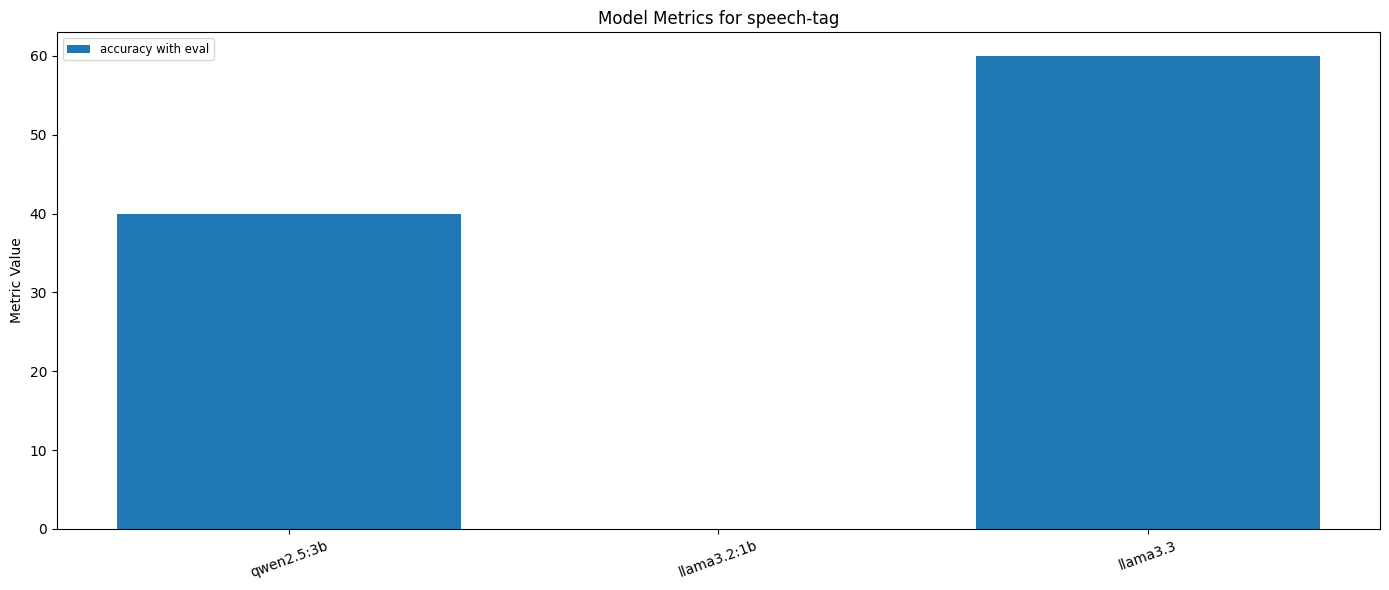

Analyzing metrics for benchmark: classify-input-text
Metrics by Model for benchmark 'classify-input-text':
      model  accuracy with eval
 qwen2.5:3b                79.0
llama3.2:1b                60.0
   llama3.3               100.0


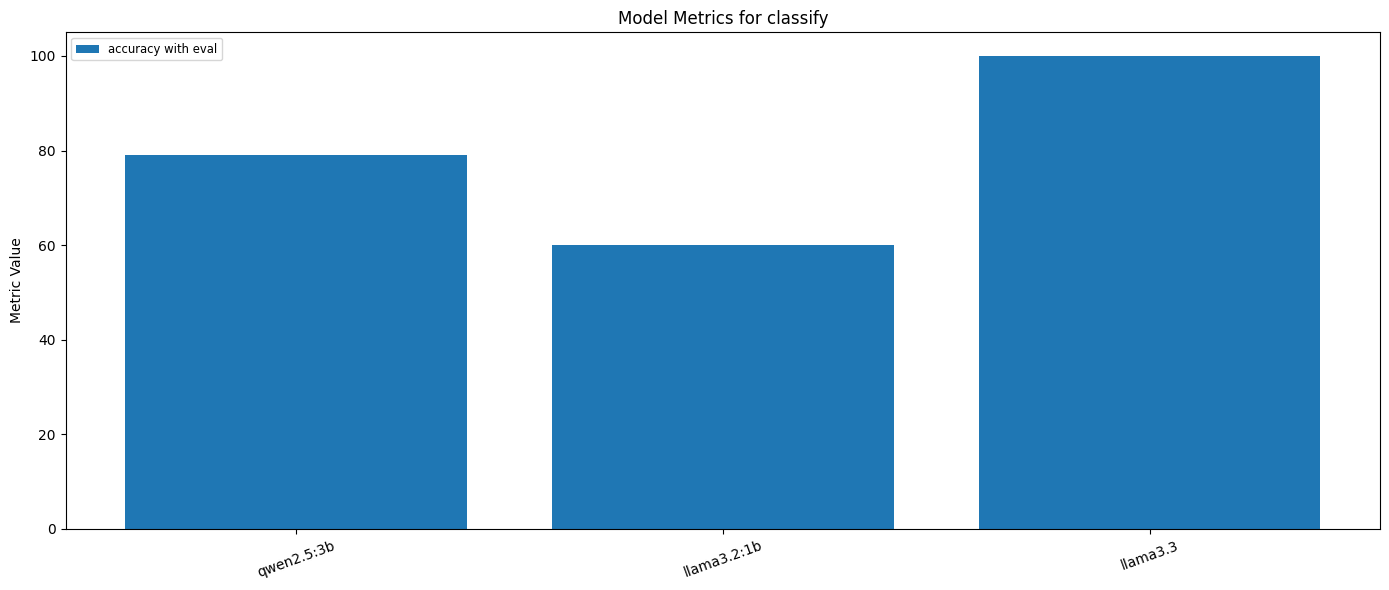

Analyzing metrics for benchmark: text-to-p
Metrics by Model for benchmark 'text-to-p':
      model  accuracy with eval
 qwen2.5:3b                33.0
llama3.2:1b                 6.0
   llama3.3                90.0


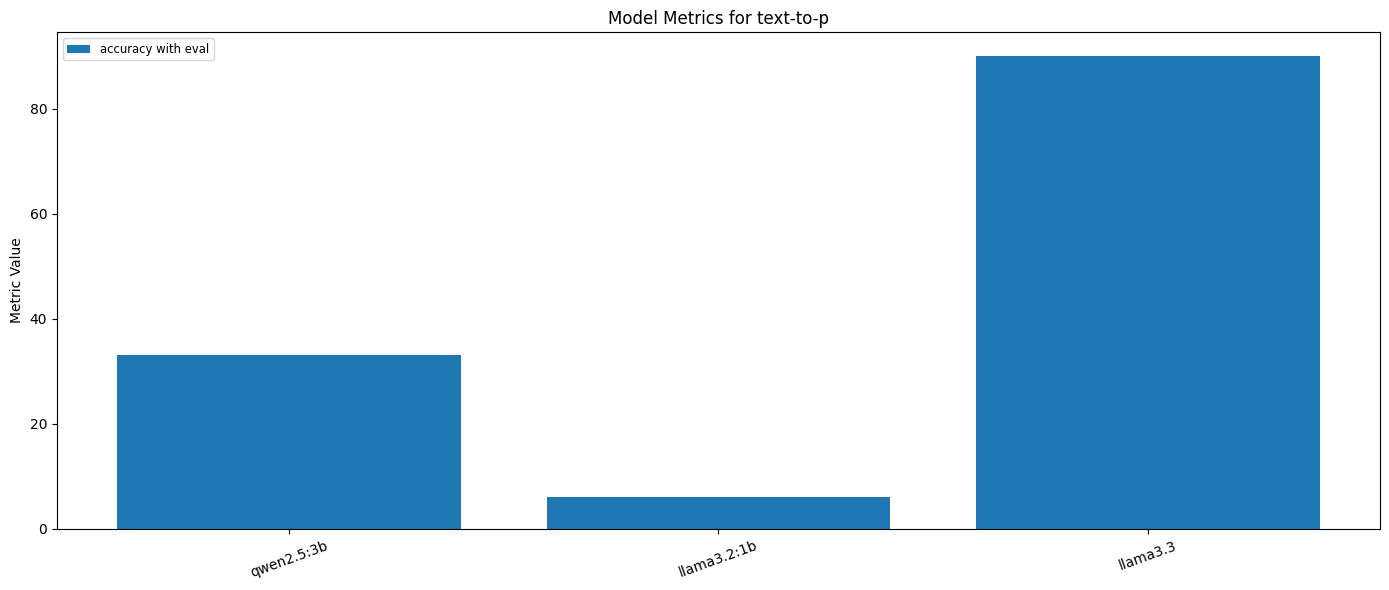

Analyzing metrics for benchmark: sentence-rewrite
Metrics by Model for benchmark 'sentence-rewrite':
      model  accuracy with eval
 qwen2.5:3b                78.0
llama3.2:1b                48.0
   llama3.3               100.0


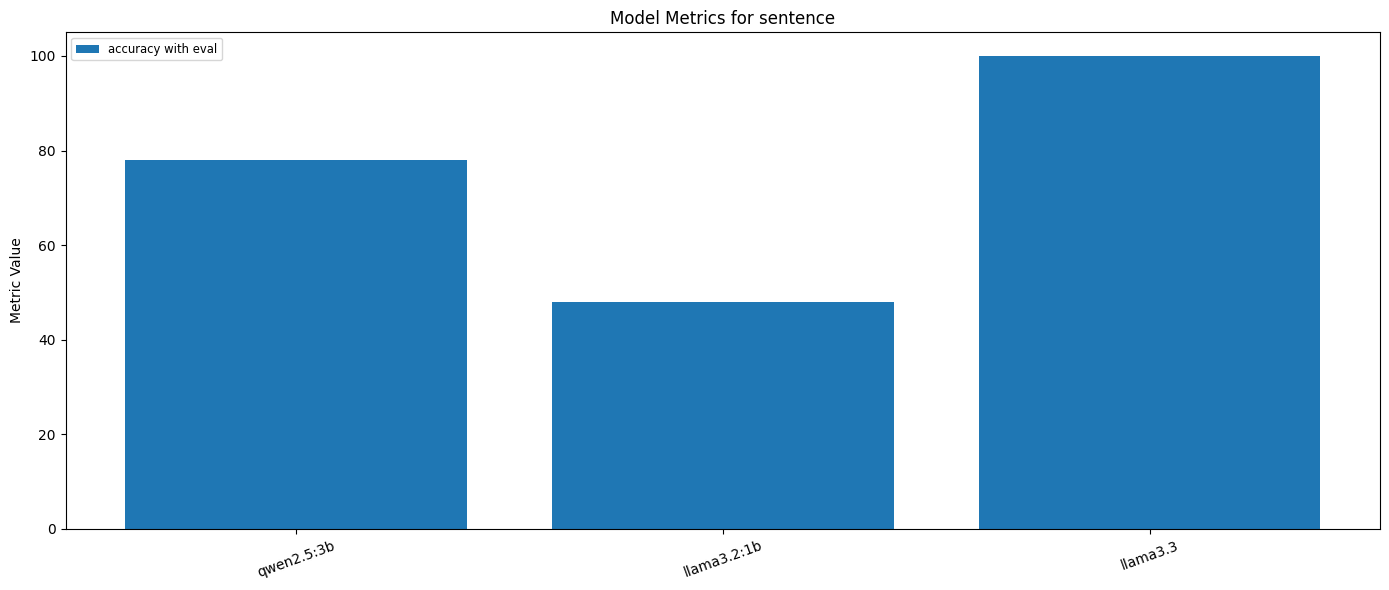

Analyzing metrics for benchmark: extract-names
Metrics by Model for benchmark 'extract-names':
      model  accuracy with eval
 qwen2.5:3b                30.0
llama3.2:1b                30.0
   llama3.3                90.1


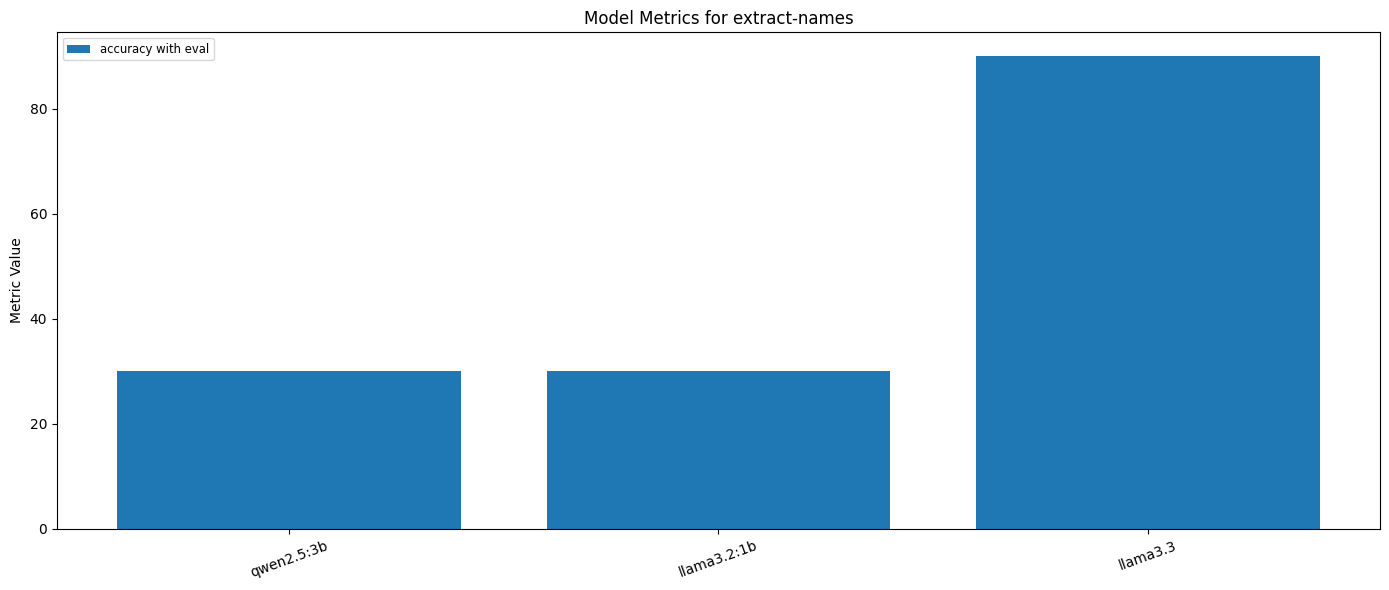

Analyzing metrics for benchmark: elements
Metrics by Model for benchmark 'elements':
      model  accuracy with eval
 qwen2.5:3b                76.0
llama3.2:1b                39.0
   llama3.3                90.0


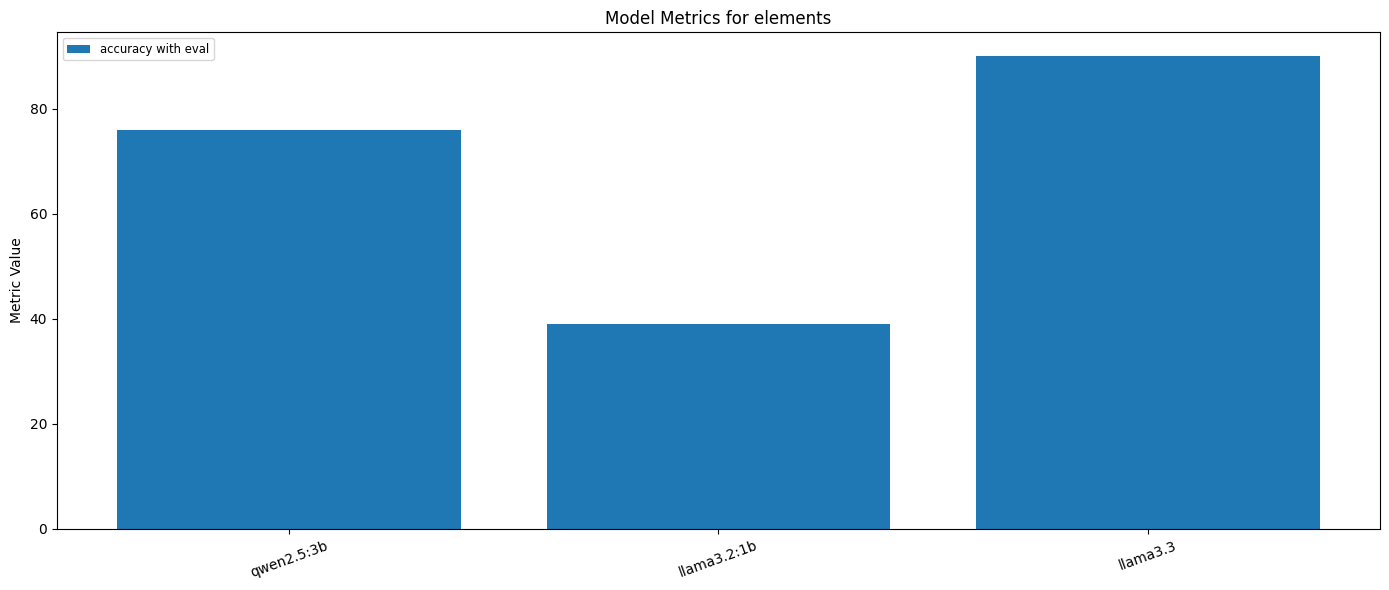

Analyzing metrics for benchmark: art-prompt
Metrics by Model for benchmark 'art-prompt':
      model  accuracy with eval
 qwen2.5:3b                73.0
llama3.2:1b                27.0
   llama3.3               100.0


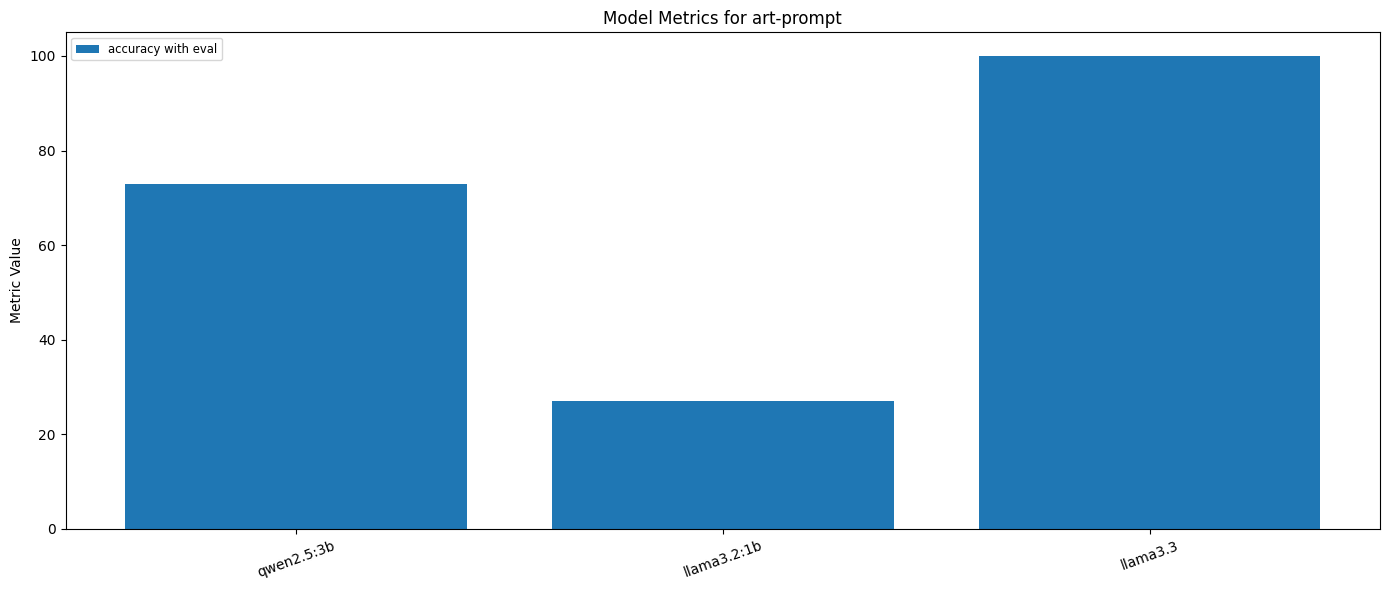

Analyzing metrics for benchmark: shakespearean-writing-assistant
Metrics by Model for benchmark 'shakespearean-writing-assistant':
      model  accuracy with eval
 qwen2.5:3b                71.5
llama3.2:1b                64.0
   llama3.3                80.0


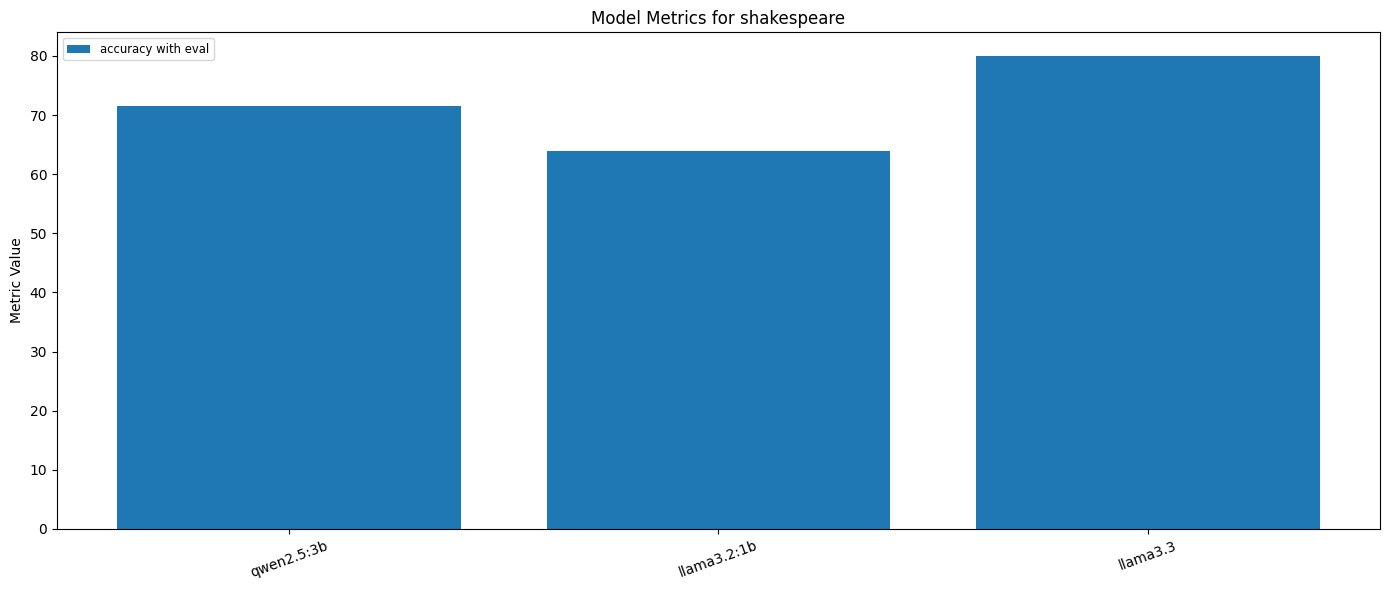

In [22]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

benchmarkVersion = "test-all-2025-07-22"

rootDir = "/workspaces/promptpex/"

if not os.path.isdir(rootDir):
    rootDir = ".."

evalsDir = f'{rootDir}/evals/{benchmarkVersion}/'



benchmarks = [
    "speech-tag"
]

# full list
benchmarks = [ "speech-tag", "classify-input-text", "text-to-p",  "sentence-rewrite", "extract-names", "elements", "art-prompt", "shakespearean-writing-assistant"]


prettyBenchmarkNames = { "speech-tag": "speech-tag", 
                "text-to-p": "text-to-p",  
                "shakespearean-writing-assistant": "shakespeare", 
                "sentence-rewrite": "sentence", 
                "extract-names": "extract-names", 
                "elements":"elements", 
                "art-prompt": "art-prompt", 
                "classify-input-text": "classify"}

prettyMetrics = { "tests compliant": "prompt ok/err", 
                "system_compliant": "prompt only",  
                "rules_system_with_input_compliant": "prompt/rule/input"
}

def parse_metric(val):
    """Convert metric to float, handle %, NaN, and '--'."""
    if isinstance(val, str):
        val = val.strip()
        if val.endswith('%'):
            try:
                return float(val.strip('%'))
            except:
                return 0.0
        if val in ('NaN', '--', ''):
            return 0.0
    try:
        v = float(val)
        if np.isnan(v):
            return 0.0
        return v
    except:
        return 0.0
    
    
def analyze_benchmark_metrics(benchmark, evalsDir, prettyBenchmarkNames):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Build the path to the overview.csv for the given benchmark
    csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")

    # Read the CSV
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()  # Strip whitespace from column names

    # Find the index of the 'tests valid compliant' column
    start_col = df.columns.get_loc('tests negative') + 1

    # Include "tests compliant" as a metric (ensure it's included)
    # metrics = ['tests compliant'] + list(df.columns[start_col:])
    metrics = list(df.columns[start_col:])

    # Extract model names and metrics columns
    models = df['model']
    metrics_table = df[['model'] + metrics].copy()

    for metric in metrics:
        metrics_table[metric] = metrics_table[metric].apply(parse_metric)

    print(f"Metrics by Model for benchmark '{benchmark}':")
    print(metrics_table.to_string(index=False))

    # Plot grouped bar chart
    x = np.arange(len(models))
    width = 0.8 / len(metrics)  # total width for all bars per group

    fig, ax = plt.subplots(figsize=(14, 6))
    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, metrics_table[metric], width, label=metric)

    ax.set_xticks(x + width*(len(metrics)-1)/2)
    ax.set_xticklabels(models, rotation=20)
    ax.set_ylabel('Metric Value')
    ax.set_title(f"Model Metrics for {prettyBenchmarkNames.get(benchmark, benchmark)}")
    ax.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

# Example usage:
for benchmark in benchmarks:
    # Call the function to analyze and plot metrics for each benchmark
    print(f"Analyzing metrics for benchmark: {benchmark}")
    analyze_benchmark_metrics(benchmark, evalsDir, prettyBenchmarkNames)


# Per-Benchmark Model Metrics Table
This section prints a table of selected metrics for each model and benchmark.

Average Metrics by Model:
Model	accuracy with eval
llama3.2:1b	34.25
llama3.3	88.76
qwen2.5:3b	60.06


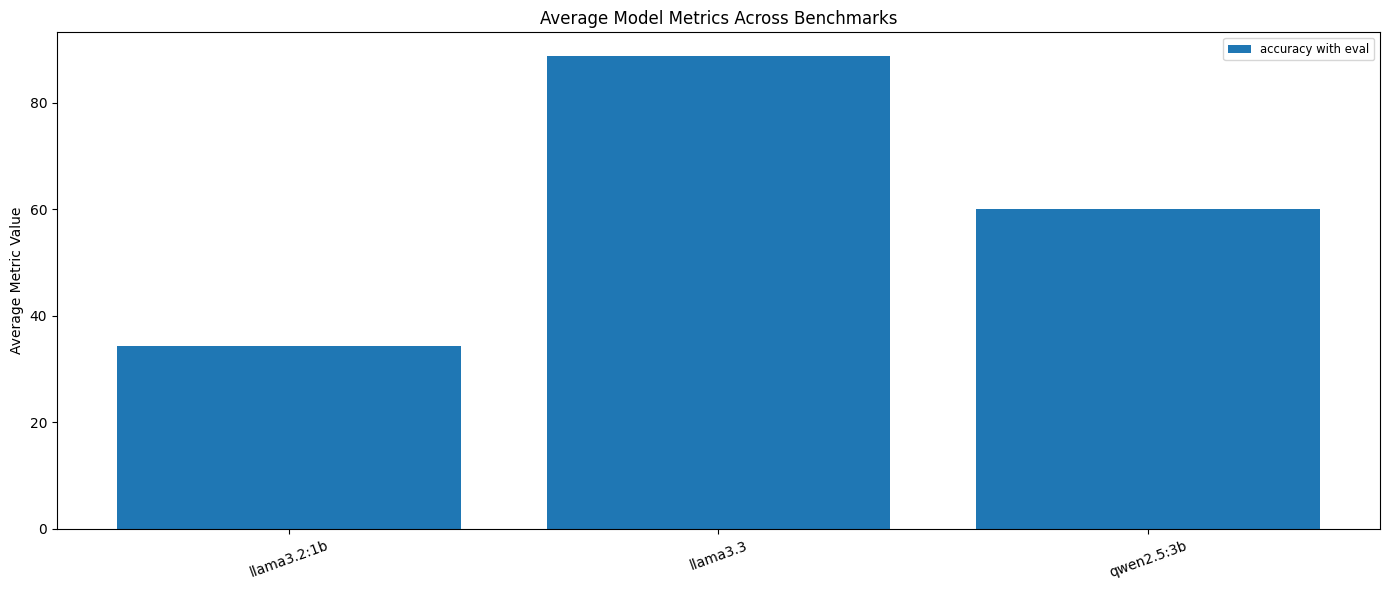

In [23]:


def collect_metrics(benchmarks, evalsDir):
    # Data structure: {benchmark: {model: {metric: value}}}
    all_data = {}
    all_metrics = set()
    all_models = set()

    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        # Find metrics columns
        start_col = df.columns.get_loc('tests negative') + 1
        # metrics = ['tests compliant'] + list(df.columns[start_col:])
        metrics = list(df.columns[start_col:])
        all_metrics.update(metrics)
        all_data[benchmark] = {}
        for _, row in df.iterrows():
            model = row['model']
            all_models.add(model)
            all_data[benchmark].setdefault(model, {})
            for metric in metrics:
                all_data[benchmark][model][metric] = parse_metric(row[metric])
    return all_data, sorted(all_models), sorted(all_metrics)

def compute_model_metric_averages(all_data, all_models, all_metrics):
    # {model: {metric: [values...]}}
    model_metric_values = {model: {metric: [] for metric in all_metrics} for model in all_models}
    for benchmark in all_data:
        for model in all_models:
            model_metrics = all_data[benchmark].get(model, {})
            for metric in all_metrics:
                val = model_metrics.get(metric, 0.0)
                model_metric_values[model][metric].append(val)
    # Compute averages
    model_metric_avg = {model: {metric: np.mean(vals) for metric, vals in metrics.items()} for model, metrics in model_metric_values.items()}
    return model_metric_avg

def print_metric_table(model_metric_avg):
    models = list(model_metric_avg.keys())
    metrics = list(next(iter(model_metric_avg.values())).keys())
    print("Average Metrics by Model:")
    header = ["Model"] + [prettyMetrics.get(m, m) for m in metrics]
    
    print("\t".join(header))
    for model in models:
        row = [model] + [f"{model_metric_avg[model][metric]:.2f}" for metric in metrics]
        print("\t".join(row))

def plot_grouped_bar_chart(model_metric_avg):
    models = list(model_metric_avg.keys())
    metrics = list(next(iter(model_metric_avg.values())).keys())
    x = np.arange(len(models))
    width = 0.8 / len(metrics)
    fig, ax = plt.subplots(figsize=(14, 6))
    for i, metric in enumerate(metrics):
        values = [model_metric_avg[model][metric] for model in models]
        ax.bar(x + i*width, values, width, label=metric)
    ax.set_xticks(x + width*(len(metrics)-1)/2)
    ax.set_xticklabels(models, rotation=20)
    ax.set_ylabel('Average Metric Value')
    ax.set_title('Average Model Metrics Across Benchmarks')
    ax.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()



all_data, all_models, all_metrics = collect_metrics(benchmarks, evalsDir)
model_metric_avg = compute_model_metric_averages(all_data, all_models, all_metrics)
print_metric_table(model_metric_avg)
plot_grouped_bar_chart(model_metric_avg)

In [24]:

def print_benchmark_model_metrics_table(benchmarks, evalsDir, columns_of_interest):
    import os
    import pandas as pd
    
    width = 18
    def fit(val):
        s = str(val)
        return s[:width].ljust(width)[:width] 
    
    header = ["Benchmark", "Model"] + [
        prettyMetrics.get(col, col) for col in columns_of_interest
    ]

    print("".join([fit(h) for h in header]))
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()

        for _, row in df.iterrows():
            model = row['model']
            values = []
            for col in columns_of_interest:
                val0 = row.get(col, 0)
                val = parse_metric(val0)
                values.append(f"{val:.2f}")
            print("".join([fit(benchmark), fit(model)] + [fit(v) for v in values]))

# read csv for first benchmark
csv_path = os.path.join(evalsDir, benchmarks[0], benchmarks[0], "overview.csv")
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()
start_col = df.columns.get_loc('tests negative') + 1
# columns_of_interest = ["tests", "tests compliant", "errors", "tests compliance unknown"] + list(df.columns[start_col:])
# columns_of_interest = ["tests compliant"] + list(df.columns[start_col:])
columns_of_interest = list(df.columns[start_col:])

print_benchmark_model_metrics_table(benchmarks, evalsDir, columns_of_interest)

Benchmark         Model             accuracy with eval
speech-tag        qwen2.5:3b        40.00             
speech-tag        llama3.2:1b       0.00              
speech-tag        llama3.3          60.00             
classify-input-texqwen2.5:3b        79.00             
classify-input-texllama3.2:1b       60.00             
classify-input-texllama3.3          100.00            
text-to-p         qwen2.5:3b        33.00             
text-to-p         llama3.2:1b       6.00              
text-to-p         llama3.3          90.00             
sentence-rewrite  qwen2.5:3b        78.00             
sentence-rewrite  llama3.2:1b       48.00             
sentence-rewrite  llama3.3          100.00            
extract-names     qwen2.5:3b        30.00             
extract-names     llama3.2:1b       30.00             
extract-names     llama3.3          90.10             
elements          qwen2.5:3b        76.00             
elements          llama3.2:1b       39.00             
elements  

# Average Number of Tests per Model by Benchmark
This section computes and visualizes the average number of tests per model for each benchmark.

Benchmark	errors	tests compliance unknown
speech-tag	0.00	0.00
classify-input-text	0.00	0.00
text-to-p	0.00	0.00
sentence-rewrite	0.00	0.00
extract-names	0.00	0.00
elements	0.00	0.00
art-prompt	0.00	0.00
shakespearean-writing-assistant	0.00	0.00


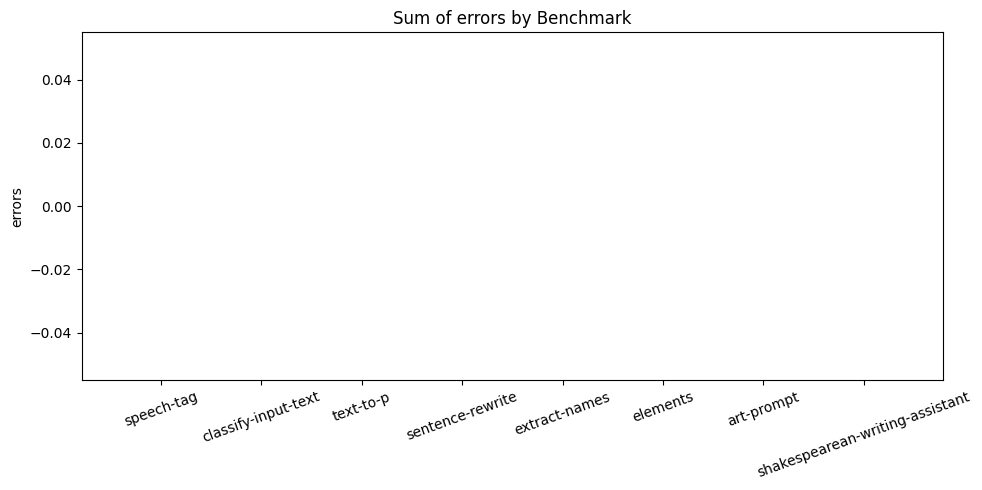

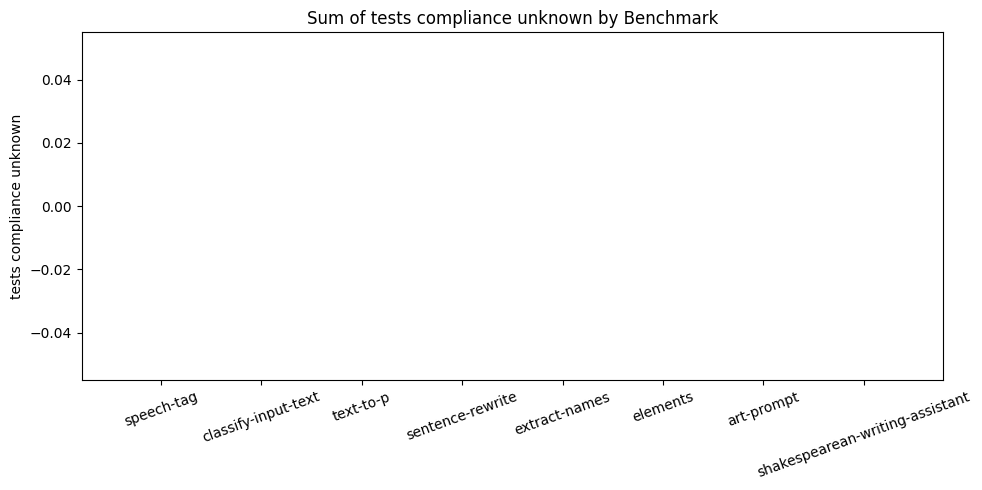

In [25]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def collect_and_sum_benchmark_metrics(benchmarks, evalsDir, columns_of_interest):
    # data[benchmark][model][column]
    data = {}
    sums = {bench: {col: 0.0 for col in columns_of_interest} for bench in benchmarks}
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        data[benchmark] = {}
        for _, row in df.iterrows():
            model = row['model']
            data[benchmark][model] = {}
            for col in columns_of_interest:
                val = parse_metric(row.get(col, 0))
                data[benchmark][model][col] = val
                sums[benchmark][col] += val
    return data, sums

def print_sums_table(sums, columns_of_interest):
    print("Benchmark\t" + "\t".join(columns_of_interest))
    for bench, colvals in sums.items():
        row = [bench] + [f"{colvals[col]:.2f}" for col in columns_of_interest]
        print("\t".join(row))

def plot_sums_bar(sums, columns_of_interest):
    benchmarks = list(sums.keys())
    for col in columns_of_interest:
        values = [sums[bench][col] for bench in benchmarks]
        plt.figure(figsize=(10, 5))
        plt.bar(benchmarks, values)
        plt.ylabel(col)
        plt.title(f"Sum of {col} by Benchmark")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()

columns_of_interest = ["errors", "tests compliance unknown"]

data, sums = collect_and_sum_benchmark_metrics(benchmarks, evalsDir, columns_of_interest)
print_sums_table(sums, columns_of_interest)
plot_sums_bar(sums, columns_of_interest)

# Average Number of Tests per Model by Benchmark
This section computes and visualizes the average number of tests per model for each benchmark.

Benchmark	Average Tests per Model
speech-tag	20.00
classify-input-text	20.00
text-to-p	20.00
sentence-rewrite	20.00
extract-names	20.00
elements	20.00
art-prompt	20.00
shakespearean-writing-assistant	20.00


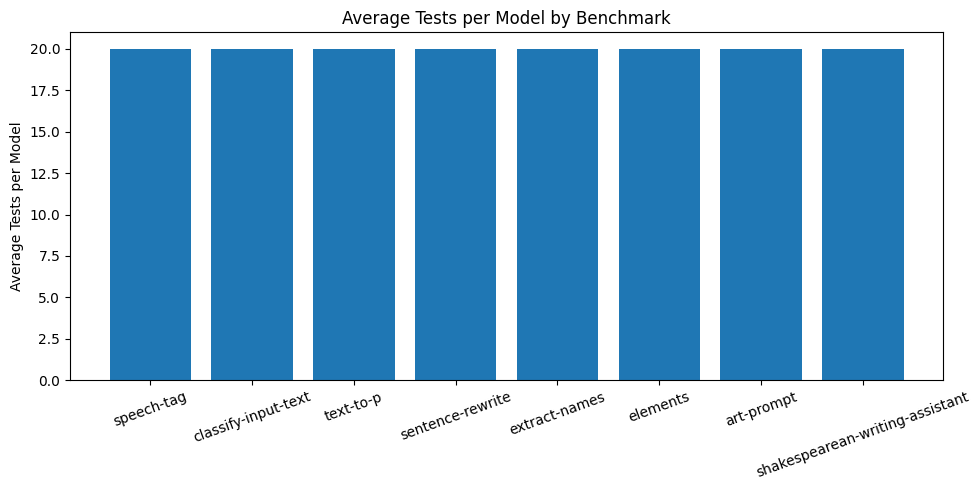

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



def average_tests_per_model(benchmarks, evalsDir):
    averages = {}
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        # Parse the 'tests' column for all models
        tests = df['tests'].apply(parse_metric)
        if len(tests) > 0:
            avg = np.mean(tests)
        else:
            avg = 0.0
        averages[benchmark] = avg
    return averages

def print_avg_table(averages):
    print("Benchmark\tAverage Tests per Model")
    for bench, avg in averages.items():
        print(f"{bench}\t{avg:.2f}")

def plot_avg_bar(averages):
    benchmarks = list(averages.keys())
    values = list(averages.values())
    plt.figure(figsize=(10, 5))
    plt.bar(benchmarks, values)
    plt.ylabel("Average Tests per Model")
    plt.title("Average Tests per Model by Benchmark")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()



averages = average_tests_per_model(benchmarks, evalsDir)
print_avg_table(averages)
plot_avg_bar(averages)

# Plotting Any Metric by Benchmark and Model
This cell defines and demonstrates a function that, for a given list of benchmarks and a metric name, loads the metric for each model, plots a grouped bar chart (grouped by benchmark, colored by model), and also shows the overall average for each model across all benchmarks as a separate group.

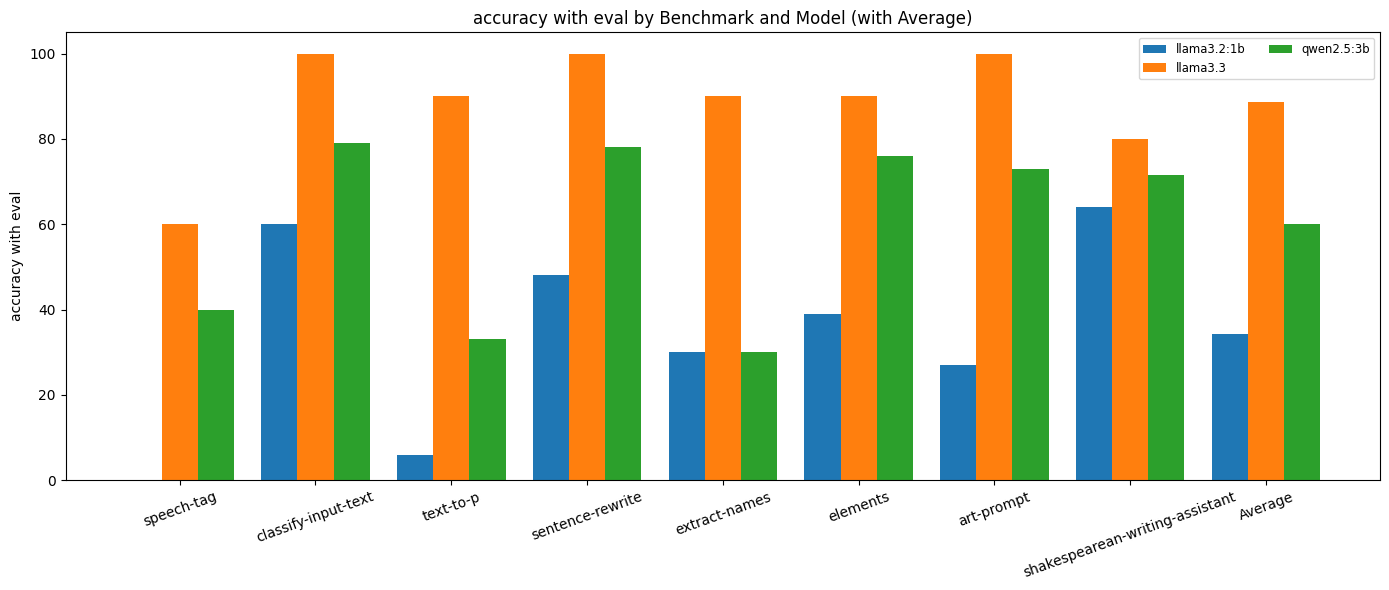

In [27]:
def plot_metric_by_benchmark_and_model(benchmarks, evalsDir, metric_name):
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Data structure: {benchmark: {model: value}}
    data = {}
    all_models = set()
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        if "model" not in df.columns or metric_name not in df.columns:
            print(f"Warning: Required columns not found in {csv_path}, skipping.")
            continue
        data[benchmark] = {}
        for _, row in df.iterrows():
            model = row["model"]
            val = parse_metric(row[metric_name])
            data[benchmark][model] = val
            all_models.add(model)
    all_models = sorted(all_models)
    
    # Build data matrix: rows=benchmarks, columns=models
    values = []
    for benchmark in benchmarks:
        row = []
        for model in all_models:
            row.append(data.get(benchmark, {}).get(model, 0.0))
        values.append(row)
    values = np.array(values)  # shape: (num_benchmarks, num_models)
    
    # Compute overall average for each model (across benchmarks)
    averages = np.mean(values, axis=0)
    
    # Add an extra group for averages
    values_with_avg = np.vstack([values, averages])
    group_labels = benchmarks + ["Average"]
    
    # Plot grouped bar chart
    x = np.arange(len(group_labels))
    width = 0.8 / len(all_models)
    fig, ax = plt.subplots(figsize=(14, 6))
    for i, model in enumerate(all_models):
        ax.bar(x + i*width, values_with_avg[:, i], width, label=model)
    
    ax.set_xticks(x + width*(len(all_models)-1)/2)
    ax.set_xticklabels(group_labels, rotation=20)
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by Benchmark and Model (with Average)')
    ax.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_metric_by_benchmark_and_model(benchmarks, evalsDir, "accuracy with eval")